In [1]:
import numpy as np
# charger les données
import pandas as pd
data = pd.read_csv('winequality-white.csv', sep=';')

# créer la matrice de données
X = data[data.columns[:-1]].values

# créer le vecteur d'étiquettes
y = data['quality'].values

# transformer en un problème de classification binaire
y_class = np.where(y<6, 0, 1)

In [2]:
# Separation des donnees en training et test

from sklearn import model_selection
X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X, y_class, test_size=0.3)


In [3]:
# standardiser les données pour qu'elles soient a peu pres toutes a la meme echelle

from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(X_train)

X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

In [4]:
# Entrainement dun premier SVM a noyau

# Créer une SVM avec un noyau gaussien de paramètre gamma=0.01
from sklearn import svm
classifier = svm.SVC(kernel='rbf', gamma=0.01)

# Entraîner la SVM sur le jeu d'entraînement
classifier.fit(X_train_std, y_train)

SVC(gamma=0.01)

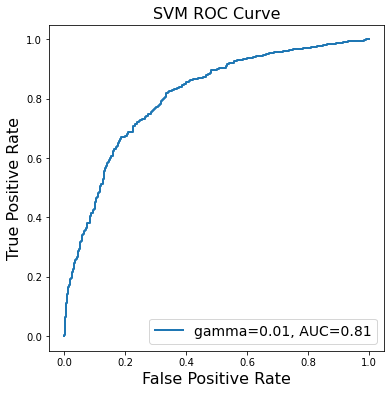

In [5]:
# Courbe ROC pour comprendre comment se comporte notre regression sur le jeu test

# prédire sur le jeu de test
y_test_pred = classifier.decision_function(X_test_std)

# construire la courbe ROC
from sklearn import metrics
fpr, tpr, thr = metrics.roc_curve(y_test, y_test_pred)

# calculer l'aire sous la courbe ROC
auc = metrics.auc(fpr, tpr)

# créer une figure
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(6, 6))

# afficher la courbe ROC
plt.plot(fpr, tpr, '-', lw=2, label='gamma=0.01, AUC=%.2f' % auc)

# donner un titre aux axes et au graphique
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('SVM ROC Curve', fontsize=16)

# afficher la légende
plt.legend(loc="lower right", fontsize=14)

# afficher l'image
plt.show()

In [6]:
# Validation croisee pour avoir les meilleurs hyperparametre (C et Gamma)

# choisir 6 valeurs pour C, entre 1e -2 et 1e 3
C_range = np.logspace(-2, 3, 6)

# choisir 4 valeurs pour gamma, entre 1e -2 et 10
gamma_range = np.logspace(-2, 1, 4)

# grille de paramètres
param_grid = {'C': C_range, 'gamma': gamma_range}

# critère de sélection du meilleur modèle
score = 'roc_auc'

# initialiser une recherche sur grille
grid = model_selection.GridSearchCV(svm.SVC(kernel='rbf'), 
                                    param_grid, 
                                    cv=5, # 5 folds de validation croisée  
                                    scoring=score)

# faire tourner la recherche sur grille
grid.fit(X_train_std, y_train)

# afficher les paramètres optimaux
print("The optimal parameters are {} with a score of {:.2f}".format(grid.best_params_, grid.best_score_))

The optimal parameters are {'C': 1.0, 'gamma': 1.0} with a score of 0.85


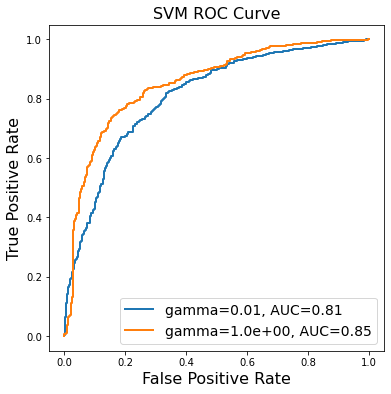

In [7]:
# prédire sur le jeu de test avec le modèle optimisé
y_test_pred_cv = grid.decision_function(X_test_std)

# construire la courbe ROC du modèle optimisé
fpr_cv, tpr_cv, thr_cv = metrics.roc_curve(y_test, y_test_pred_cv)

# calculer l'aire sous la courbe ROC du modèle optimisé
auc_cv = metrics.auc(fpr_cv, tpr_cv)

# créer une figure
fig = plt.figure(figsize=(6, 6))

# afficher la courbe ROC précédente
plt.plot(fpr, tpr, '-', lw=2, label='gamma=0.01, AUC=%.2f' % auc)

# afficher la courbe ROC du modèle optimisé
plt.plot(fpr_cv, tpr_cv, '-', lw=2, label='gamma=%.1e, AUC=%.2f' % \
         (grid.best_params_['gamma'], auc_cv))
         

# donner un titre aux axes et au graphique
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('SVM ROC Curve', fontsize=16)

# afficher la légende
plt.legend(loc="lower right", fontsize=14)

# afficher l'image
plt.show()

### Matrice de Gram ###

Si la matrice de Gram a une diagonnale a forte dominance, elle se rapproche de la matrice identitaire et la SVM ne pourra pas bien apprendre

In [8]:
# Matrice de Gram pour gamma = 0,01

from sklearn import metrics
kmatrix = metrics.pairwise.rbf_kernel(X_train_std, gamma=0.01)

In [9]:
# On ne prend que les 100 premieres lignes et colonnes pour la visualisation

kmatrix100 = kmatrix[:100, :100]

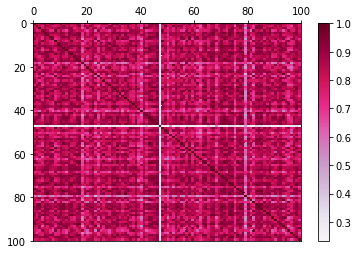

In [11]:
# Visualisation de la matrice avec pcolor
import matplotlib

# dessiner la matrice
plt.pcolor(kmatrix100, cmap=matplotlib.cm.PuRd) 

# rajouter la légende
plt.colorbar()

# retourner l'axe des ordonnées
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()

# afficher l'image
plt.show()

#### Ici la courbe n'ecrase pas la matrice ####
#### Si on fait pareil avec un gamma = 50, on a une courbe ecrasante et le ROC sera moins bon ####

In [13]:
# Matrice de Gram pour gamma = 0,01

from sklearn import metrics
kmatrix = metrics.pairwise.rbf_kernel(X_train_std, gamma=50)

In [14]:
# On ne prend que les 100 premieres lignes et colonnes pour la visualisation

kmatrix100 = kmatrix[:100, :100]

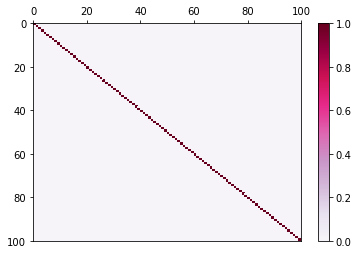

In [15]:
# Visualisation de la matrice avec pcolor
import matplotlib

# dessiner la matrice
plt.pcolor(kmatrix100, cmap=matplotlib.cm.PuRd) 

# rajouter la légende
plt.colorbar()

# retourner l'axe des ordonnées
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()

# afficher l'image
plt.show()

#### Que faire si la matrice de Gram est dominée par sa diagonale ? Deux choix sont possibles : ####

    jouer avec les paramètres du noyau pour réduire la différence entre les valeurs diagonales et les valeurs hors diagonale

    remplacer la matrice de Gram K par la matrice M telle que Mil=KilKiiKll√

. Les valeurs diagonales de cette matrice seront de 1.

Il est aussi possible que les **paramètres du noyau** soient tels que toutes les valeurs de la matrice de Gram sont **proches** les unes des autres. Dans ce cas, la SVM ne peut **pas bien apprendre non plus** : c'est comme si on lui avait dit que **tous les points sont quasi-identiques**...